In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10726858435572020057
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3208631933059922297
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
import os
import math
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
tf.__version__

'2.0.0-beta0'

In [6]:
def rgb2gray(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

In [7]:
targets = pd.Series.from_csv('data_csv/jester-v1-train.csv',header=None,sep = ";").to_dict()
targets_validation = pd.Series.from_csv('data_csv/jester-v1-validation.csv',header=None,sep = ";").to_dict()


C:\Users\UCA\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


'Thumb Up'

In [8]:
len(targets)
targets[100000]

'Thumb Up'

In [9]:
targets_name = [
    "Swiping Right",
    "Sliding Two Fingers Left",
    "No gesture",
    "Thumb Up"
    ]

In [11]:
path = "training_samples/"
path_cv = "validation_samples/"

dirs = os.listdir(path)
dirs_cv = os.listdir(path_cv)

In [12]:
print(len(dirs))
print(len(dirs_cv))

6000
1971


In [13]:
training_count = 10


In [14]:
hm_frames = 30 
def get_unify_frames(path):
    offset = 0
    frames = os.listdir(path)
    frames_count = len(frames)
    if hm_frames > frames_count:
        frames += [frames[-1]] * (hm_frames - frames_count)
    elif hm_frames < frames_count:
        frames = frames[0:hm_frames]
    return frames  

In [15]:
def resize_frame(frame):
    frame = img.imread(frame)
    frame = cv2.resize(frame, (64, 64))
    return frame
    

In [16]:
counter_training = 0 
training_targets = [] 
new_frames = [] 
for directory in dirs:
    new_frame = [] 
    frames = get_unify_frames(path+directory)
    if len(frames) == hm_frames: 
        for frame in frames:
            frame = resize_frame(path+directory+'/'+frame)
            new_frame.append(rgb2gray(frame))
            if len(new_frame) == 15:
                new_frames.append(new_frame) 
                training_targets.append(targets_name.index(targets[int(directory)]))
                counter_training +=1
                new_frame = []

In [17]:
counter_validation = 0
cv_targets = []
new_frames_cv = []
for directory in dirs_cv:
    new_frame = []
    frames = get_unify_frames(path_cv+directory)
    if len(frames)==hm_frames:
        for frame in frames:
            frame = resize_frame(path_cv+directory+'/'+frame)
            new_frame.append(rgb2gray(frame))
            if len(new_frame) == 15:
                new_frames_cv.append(new_frame)
                cv_targets.append(targets_name.index(targets_validation[int(directory)]))
                counter_validation +=1
                new_frame = []

In [18]:
print(len(new_frames))
print(len(training_targets))

12000
12000


In [19]:
print(len(new_frames_cv))
print(len(cv_targets))

3942
3942


In [20]:
training_targets[0:20]

[0, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 0, 0, 3, 3, 3, 3]

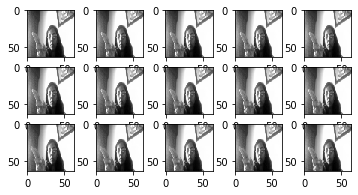

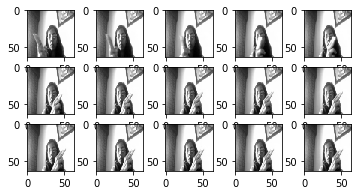

<Figure size 432x288 with 0 Axes>

In [21]:
fig = plt.figure()
for i in range(2,4):
    for num,frame in enumerate(new_frames[i][0:18]):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(frame, cmap='gray')
    fig = plt.figure()
plt.show()

In [22]:
training_data = np.array(new_frames[0:counter_training], dtype=np.float32)

In [23]:
def release_list(a):
   del a[:]
   del a

In [24]:
release_list(new_frames)

In [26]:
cv_data = np.array(new_frames_cv[0:counter_validation], dtype=np.float32)

In [27]:
release_list(new_frames_cv)

In [25]:
training_data.shape

(12000, 15, 64, 64)

In [28]:
cv_data.shape

(3942, 15, 64, 64)

In [29]:
print('old mean', training_data.mean())
scaler = StandardScaler()
scaled_images  = scaler.fit_transform(training_data.reshape(-1, 15*64*64))
print('new mean', scaled_images.mean())
scaled_images  = scaled_images.reshape(-1, 15, 64, 64, 1)
print(scaled_images.shape)

109.7265
2.8716194e-09
(12000, 15, 64, 64, 1)


In [30]:
print('old mean', cv_data.mean())
scaler = StandardScaler()
scaled_images_cv  = scaler.fit_transform(cv_data.reshape(-1, 15*64*64))
print('new mean',scaled_images_cv.mean())
scaled_images_cv  = scaled_images_cv.reshape(-1, 15, 64, 64, 1)
print(scaled_images_cv.shape)

107.52739
-1.1727388e-08
(3942, 15, 64, 64, 1)


In [32]:
class Conv3DModel(tf.keras.Model):
  def __init__(self):
    super(Conv3DModel, self).__init__()
    # Convolutions
    self.conv1 = tf.compat.v2.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv2 = tf.compat.v2.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2,2), data_format='channels_last')
   
    # LSTM & Flatten
    self.convLSTM =tf.keras.layers.ConvLSTM2D(40, (3, 3))
    self.flatten =  tf.keras.layers.Flatten(name="flatten")

    # Dense layers
    self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
    self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")
    

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.convLSTM(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.out(x)

In [33]:
model = Conv3DModel()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [35]:
x_train = np.array(scaled_images)
y_train = np.array(training_targets)
x_val = np.array(scaled_images_cv)
y_val = np.array(cv_targets)

In [36]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(12000, 15, 64, 64, 1)
(12000,)
(3942, 15, 64, 64, 1)
(3942,)


In [37]:
checkpoint_path = "training_today/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
history = model.fit(x_train, y_train,
                    callbacks = [cp_callback],
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=10)

In [39]:
history.history

{'loss': [0.7653240595261256],
 'accuracy': [0.69325],
 'val_loss': [0.49401697688813984],
 'val_accuracy': [0.8409437]}

In [41]:
model.save_weights('weights/path_to_my_weights', save_format='tf')